In [1]:
import os
import rasterio
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import random
import json
from glob import glob
import os
import cv2

from tqdm import tqdm_notebook, tqdm
# import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# We write functions and classes for preprocessing and training the model - Прописываем функции и классы для предобработки и обучения модели

In [2]:
def print_geotiff_info(path):
    try:
        # Открываем файл
        with rasterio.open(path) as src:
            # Основные метаданные
            print(f"File Path: {path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            # Информация по каждому каналу
            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")

    except Exception as e:
        print(f'Error: {e}')


def visualize_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, chanel=1):
    try:
        with rasterio.open(file_path) as src:
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if chanel == 1:
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif chanel == 2:
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif chanel == 3:
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            fig, ax = plt.subplots(figsize=(10, 10))
            ax.imshow(photo)
            ax.axis('off')
            plt.show()
            return photo
    except Exception as e:
        print(f'Ошибка: {e}')


def get_rgb_geotiff(file_path, r_band, g_band, b_band, ik_band, mask_band, chanel=1):
    try:
        with rasterio.open(file_path) as src:
            red = src.read(r_band)  # B02 - Blue
            green = src.read(g_band)  # B03 - Green
            blue = src.read(b_band)  # B04 - Red
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            if chanel == 1:
                photo = np.stack([red, green, blue], axis=-1)  # Отрисовка всего изображения
            elif chanel == 2:
                photo = np.stack([ik], axis=-1) # Отрисовка ИК-слоя изображения
            elif chanel == 3:
                photo = np.stack([mask], axis=-1)  # Отрисовка маски изображения
            photo = photo.astype(np.uint8)
            return photo
    except Exception as e:
        print(f'Ошибка: {e}')


In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask_transform=None, random_params=None):
        self.dataframe = dataframe
        self.transform = transform
        self.mask_transform = mask_transform
        self.random_params = random_params

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = list(self.dataframe['img_path'])[idx]
        if img_path.endswith('.tiff'):
            image = get_rgb_geotiff(img_path, 1, 2, 3, 4, 5, chanel=1)
            image = np.clip(image.astype(float) * 3, 0, 255).astype(np.uint8)
            mask = get_rgb_geotiff(img_path, 1, 2, 3, 4, 5, chanel=3)
        else:
            image = Image.open(img_path)
            mask = Image.open(list(self.dataframe['mask_path'])[idx])
            image = np.asarray(image)
            mask = np.asarray(mask)
    
        # Приведение маски к одноканальному виду, если нужно
        if len(mask.shape) == 3 and mask.shape[2] == 3:
            mask = mask[:, :, 0]  # Берем первый канал, если маска RGB
    
        if self.random_params:
            image = self.random_params.apply(image)
            mask = self.random_params.apply(mask, mask=True)
    
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
    
        return image, mask


In [4]:
class Metrics:
    @staticmethod
    def f1_score(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        return f1.item()

    @staticmethod
    def precision(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        precision = tp / (tp + fp + 1e-6)
        return precision.item()
    
    @staticmethod
    def recall(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        recall = tp / (tp + fn + 1e-6)
        return recall.item()

    @staticmethod
    def accuracy(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        correct = (y_true == y_pred).float().sum()
        accuracy = correct / y_true.numel()
        return accuracy.item()

    @staticmethod
    def matthews_corrcoef(y_true, y_pred, threshold=0.5):
        y_pred = (y_pred > threshold).float()
        tp = (y_true * y_pred).sum().to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
        numerator = (tp * tn) - (fp * fn)
        denominator = torch.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + 1e-6)
        mcc = numerator / denominator
        return ((mcc + 1) / 2).item()

In [5]:
for i in os.listdir('cems/data'):
    for j in os.listdir(f'cems/data/{i}'):
        im = cv2.imread(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_S2L2A.png")
        im_bgr = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_S2L2A.png", im_bgr)
        im1 = cv2.imread(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_DEL.png")
        im1_bgr = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_DEL.png", im1_bgr)

# Data analysis - Анализ данных

In [6]:
data = {
    'img_path': [],
    'mask_path': [],
    'W': [],
    'H': []
}

for i in os.listdir('train'):
    data['img_path'].append(f"train/{i}/{[f for f in os.listdir(f'train/{i}') if 'tiff' in f][0]}")
    with rasterio.open(f"train/{i}/{[f for f in os.listdir(f'train/{i}') if 'tiff' in f][0]}") as src:
        data['W'].append(src.width)
        data['H'].append(src.height)
    data['mask_path'].append(np.NaN)

In [7]:
for i in os.listdir('cems/data'):
    for j in os.listdir(f'cems/data/{i}'):
        data['img_path'].append(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_S2L2A.png")
        data['mask_path'].append(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_DEL.png")
        im = Image.open(f"cems/data/{i}/{j}/{i}_{j}_01/{i}_{j}_01_S2L2A.png")
        data['W'].append(im.width)
        data['H'].append(im.height)

data = pd.DataFrame(data)
data.head(10)

img_path mask_path     W    H
0  train/13/2019-05-17.tiff       NaN   753  487
1  train/08/2021-06-08.tiff       NaN   258  172
2  train/19/2021-05-04.tiff       NaN   328  188
3  train/09/2021-06-16.tiff       NaN   135  106
4  train/15/2020-04-22.tiff       NaN   474  283
5  train/18/2021-05-02.tiff       NaN  1651  992
6  train/00/2021-06-06.tiff       NaN   215  222
7  train/07/2021-06-03.tiff       NaN   141  213
8  train/05/2021-06-03.tiff       NaN   249  204
9  train/04/2021-06-06.tiff       NaN   139  142

In [8]:
data.describe()

W            H
count   219.000000   219.000000
mean    958.899543   933.757991
std     438.115678   430.228381
min     135.000000   106.000000
25%     635.500000   671.000000
50%     820.000000   799.000000
75%    1223.500000  1165.000000
max    2045.000000  2078.000000

In [9]:
file_path = r'train/06/2021-06-03.tiff'
print_geotiff_info(file_path)

File Path: train/06/2021-06-03.tiff
Driver: GTiff
Width: 702
Height: 680
Count (Bands): 5
CRS: EPSG:4326
Transform: | 10.00, 0.00, 73.36|
| 0.00,-10.00, 55.30|
| 0.00, 0.00, 1.00|
Bounding Box: BoundingBox(left=73.35841, bottom=-6744.702852, right=7093.35841, top=55.297148)
Datum: ('float32', 'float32', 'float32', 'float32', 'float32')

Band 1:
  Data Type: float32
  Min Value: 6.0
  Max Value: 117.0
  Mean Value: 13.242181777954102
  Standard Deviation: 4.746762275695801

Band 2:
  Data Type: float32
  Min Value: 6.0
  Max Value: 116.0
  Mean Value: 17.403249740600586
  Standard Deviation: 5.346482276916504

Band 3:
  Data Type: float32
  Min Value: 4.0
  Max Value: 112.0
  Mean Value: 16.016992568969727
  Standard Deviation: 8.0848388671875

Band 4:
  Data Type: float32
  Min Value: 11.0
  Max Value: 145.0
  Mean Value: 62.35188293457031
  Standard Deviation: 12.316082000732422

Band 5:
  Data Type: float32
  Min Value: 0.0
  Max Value: 1.0
  Mean Value: 0.0070806099101901054
  Stand

Number of bands: 5


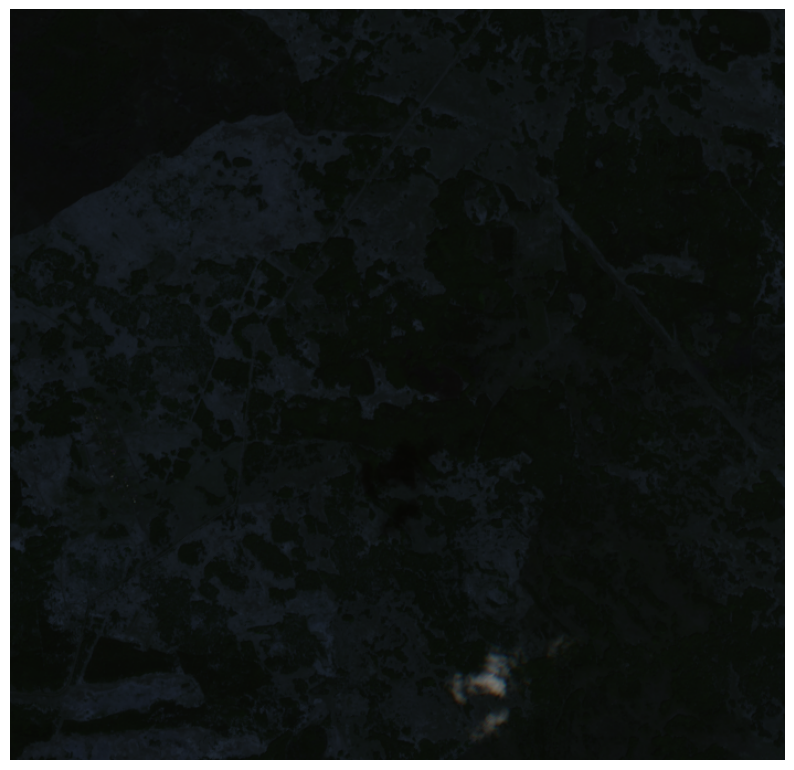

(680, 702, 3)

In [10]:
ch1 = visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5, chanel=1)
ch1.shape

Number of bands: 5


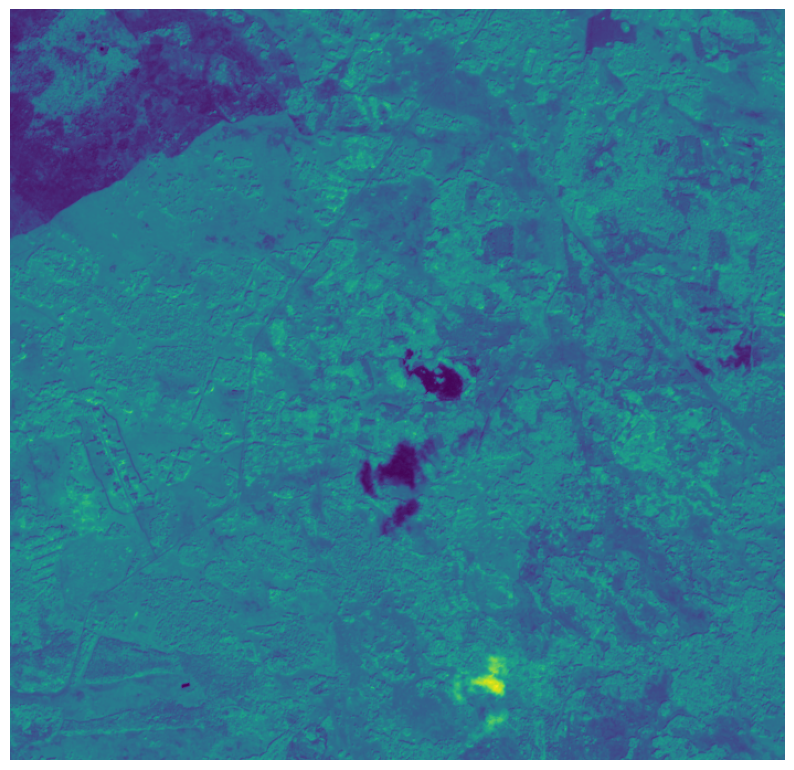

(680, 702, 1)

In [11]:
ch2 = visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5, chanel=2)
ch2.shape

Number of bands: 5


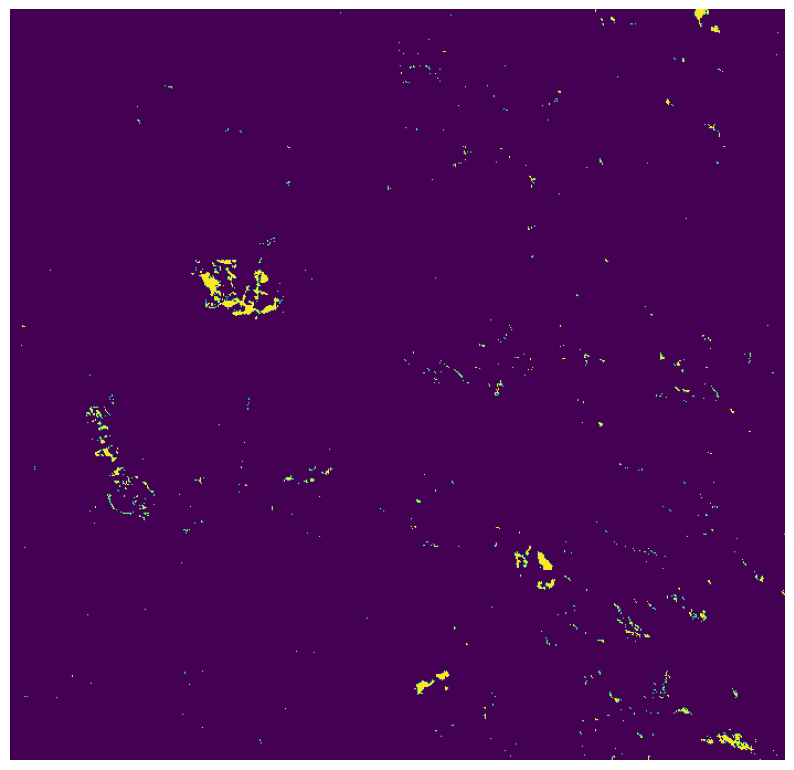

(680, 702, 1)

In [12]:
ch3 = visualize_rgb_geotiff(file_path, 1, 2, 3, 4, 5, chanel=3)
ch3.shape

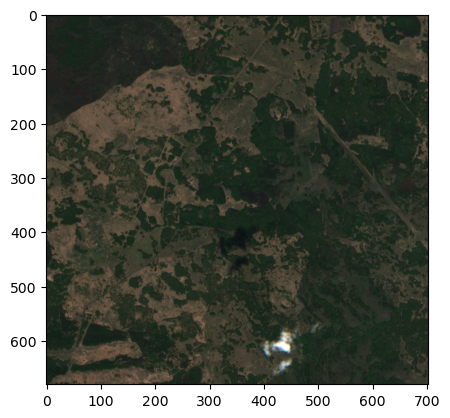

In [13]:
plt.imshow(np.clip(ch1.astype(float) * 3, 0, 255).astype(np.uint8)[:, :, ::-1])

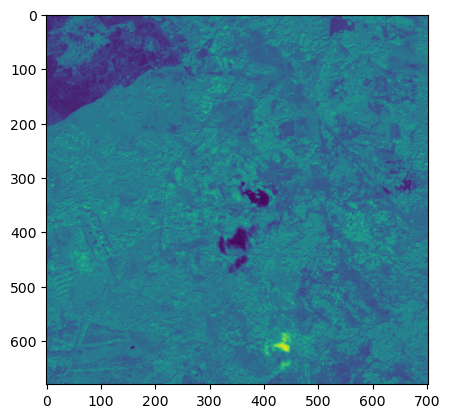

In [14]:
plt.imshow(ch2)

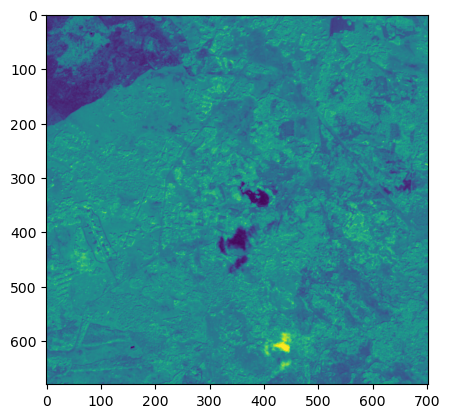

In [15]:
plt.imshow(np.clip(ch2.astype(float) * 2, 0, 255).astype(np.uint8))

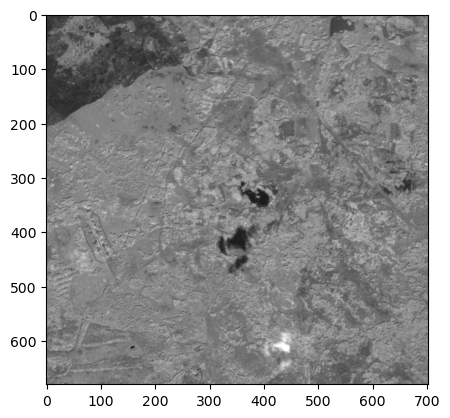

In [16]:
plt.imshow(np.repeat(np.clip(ch2.astype(float) * 2, 0, 255).astype(np.uint8), 3, axis=2))

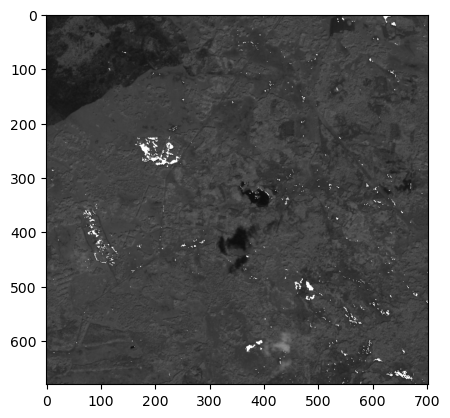

In [17]:
plt.imshow(np.repeat(np.clip(ch2.astype(float) + ch3.astype(float) * 255, 0, 255).astype(np.uint8), 3, axis=2) )

# Divide into training and validation set - Разделим на тренировочную и валидационную выборку

In [73]:
valid = data.iloc[14:35, :]
train = pd.concat([data.iloc[:14, :], data.iloc[35:, :]])

In [74]:
train

img_path  \
0                             train/13/2019-05-17.tiff   
1                             train/08/2021-06-08.tiff   
2                             train/19/2021-05-04.tiff   
3                             train/09/2021-06-16.tiff   
4                             train/15/2020-04-22.tiff   
..                                                 ...   
214  cems/data/EMSR396/AOI01/EMSR396_AOI01_01/EMSR3...   
215  cems/data/EMSR396/AOI02/EMSR396_AOI02_01/EMSR3...   
216  cems/data/EMSR396/AOI03/EMSR396_AOI03_01/EMSR3...   
217  cems/data/EMSR522/AOI01/EMSR522_AOI01_01/EMSR5...   
218  cems/data/EMSR638/AOI01/EMSR638_AOI01_01/EMSR6...   

                                             mask_path     W     H  
0                                                  NaN   753   487  
1                                                  NaN   258   172  
2                                                  NaN   328   188  
3                                                  NaN   135   106  
4                                                  NaN   474   283  
..                                                 ...   ...   ...  
214  cems/data/EMSR396/AOI01/EMSR396_AOI01_01/EMSR3...  1097   864  
215  cems/data/EMSR396/AOI02/EMSR396_AOI02_01/EMSR3...   570   937  
216  cems/data/EMSR396/AOI03/EMSR396_AOI03_01/EMSR3...   568  1311  
217  cems/data/EMSR522/AOI01/EMSR522_AOI01_01/EMSR5...  1024   805  
218  cems/data/EMSR638/AOI01/EMSR638_AOI01_01/EMSR6...   669   762  

[198 rows x 4 columns]

In [75]:
valid

img_path  \
14                           train/20/2021-05-15.tiff   
15                           train/02/2021-06-03.tiff   
16                           train/01/2021-05-26.tiff   
17                           train/16/2020-05-09.tiff   
18                           train/12/2019-05-10.tiff   
19                           train/03/2021-06-03.tiff   
20                           train/10/2021-06-16.tiff   
21  cems/data/EMSR523/AOI02/EMSR523_AOI02_01/EMSR5...   
22  cems/data/EMSR523/AOI07/EMSR523_AOI07_01/EMSR5...   
23  cems/data/EMSR523/AOI05/EMSR523_AOI05_01/EMSR5...   
24  cems/data/EMSR523/AOI08/EMSR523_AOI08_01/EMSR5...   
25  cems/data/EMSR523/AOI09/EMSR523_AOI09_01/EMSR5...   
26  cems/data/EMSR532/AOI01/EMSR532_AOI01_01/EMSR5...   
27  cems/data/EMSR583/AOI01/EMSR583_AOI01_01/EMSR5...   
28  cems/data/EMSR370/AOI01/EMSR370_AOI01_01/EMSR3...   
29  cems/data/EMSR593/AOI01/EMSR593_AOI01_01/EMSR5...   
30  cems/data/EMSR625/AOI01/EMSR625_AOI01_01/EMSR6...   
31  cems/data/EMSR625/AOI02/EMSR625_AOI02_01/EMSR6...   
32  cems/data/EMSR545/AOI01/EMSR545_AOI01_01/EMSR5...   
33  cems/data/EMSR500/AOI01/EMSR500_AOI01_01/EMSR5...   
34  cems/data/EMSR300/AOI01/EMSR300_AOI01_01/EMSR3...   

                                            mask_path     W     H  
14                                                NaN   521   342  
15                                                NaN   361   223  
16                                                NaN   191   137  
17                                                NaN   422   266  
18                                                NaN   706   463  
19                                                NaN   297   249  
20                                                NaN   381   257  
21  cems/data/EMSR523/AOI02/EMSR523_AOI02_01/EMSR5...  1759  1681  
22  cems/data/EMSR523/AOI07/EMSR523_AOI07_01/EMSR5...   655   671  
23  cems/data/EMSR523/AOI05/EMSR523_AOI05_01/EMSR5...   660  1167  
24  cems/data/EMSR523/AOI08/EMSR523_AOI08_01/EMSR5...   798   614  
25  cems/data/EMSR523/AOI09/EMSR523_AOI09_01/EMSR5...  1264  1606  
26  cems/data/EMSR532/AOI01/EMSR532_AOI01_01/EMSR5...  1417  1288  
27  cems/data/EMSR583/AOI01/EMSR583_AOI01_01/EMSR5...   610   818  
28  cems/data/EMSR370/AOI01/EMSR370_AOI01_01/EMSR3...   764   572  
29  cems/data/EMSR593/AOI01/EMSR593_AOI01_01/EMSR5...   624   675  
30  cems/data/EMSR625/AOI01/EMSR625_AOI01_01/EMSR6...  1820  1082  
31  cems/data/EMSR625/AOI02/EMSR625_AOI02_01/EMSR6...  1026  1364  
32  cems/data/EMSR545/AOI01/EMSR545_AOI01_01/EMSR5...  1302  1711  
33  cems/data/EMSR500/AOI01/EMSR500_AOI01_01/EMSR5...  1452  1053  
34  cems/data/EMSR300/AOI01/EMSR300_AOI01_01/EMSR3...  1667  1429

In [76]:
class RandomParams:
    def __init__(self):
        self.params = {
            'horizontal_flip': random.choice([0, 1]),
            'vertical_flip': random.choice([0, 1]),
            'color_jitter': random.choice([0, 1]),
            'blur': random.choice([0, 1])
        }

    def apply(self, image, mask=False):
        if not mask:
            # Convert to PIL Image if it's a NumPy array
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # Image.fromarray(image.astype('uint8'), 'RGB')
            if self.params['horizontal_flip']:
                image = transforms.RandomHorizontalFlip(p=1)(image)
            if self.params['vertical_flip']:
                image = transforms.RandomVerticalFlip(p=1)(image)
            if self.params['color_jitter']:
                image = transforms.ColorJitter(brightness=1)(image)
            if self.params['blur']:
                image = transforms.GaussianBlur((3, 3))(image)
            image = np.array(image)
            image = cv2.resize(image, (160, 128))
            image = transforms.ToTensor()(image)
            return image
        else:
            if self.params['horizontal_flip']:
                image = np.fliplr(image)
            if self.params['vertical_flip']:
                image = np.flipud(image)
            image = cv2.resize(image, (160, 128), interpolation=cv2.INTER_NEAREST)
            return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

In [77]:
image_transform = transforms.Compose([
    transforms.Lambda(lambda x: Image.fromarray(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))),
    transforms.Lambda(lambda x: cv2.resize(np.array(x), (160, 128))),  # Используем cv2.resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Lambda(lambda mask: cv2.resize(mask, (160, 128))),  # Для маски используем интерполяцию NEAREST
    transforms.Lambda(lambda mask: torch.tensor(mask, dtype=torch.float32).unsqueeze(0))  # Преобразование маски в тензор
])

In [78]:
random_params = RandomParams()

In [79]:
train_dataset = SegmentationDataset(dataframe=train, random_params=random_params)
orig_train_dataset = SegmentationDataset(dataframe=train, transform=image_transform, mask_transform=mask_transform)
valid_dataset = SegmentationDataset(dataframe=valid, transform=image_transform, mask_transform=mask_transform)

batch_size = 5
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # num_workers=8)
orig_train_dataloader = DataLoader(orig_train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # num_workers=4)

Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


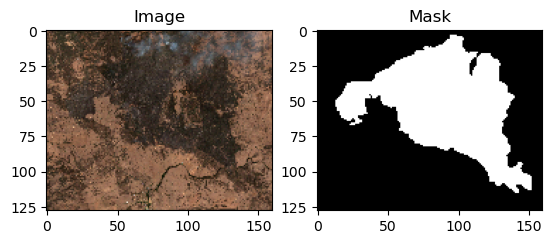

Batch 2
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


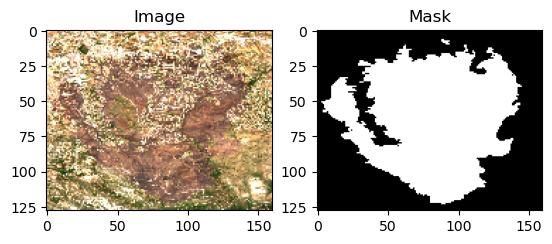

Batch 3
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


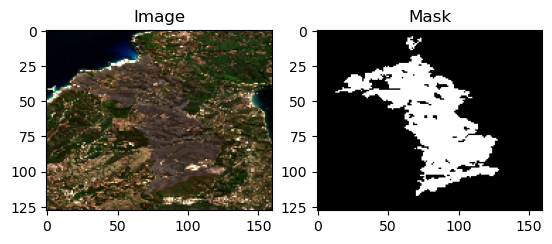

Batch 4
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


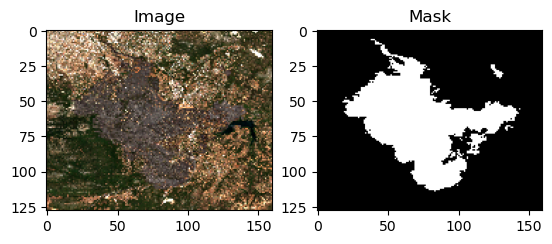

Batch 5
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])
<class 'torch.Tensor'>
<class 'torch.Tensor'>


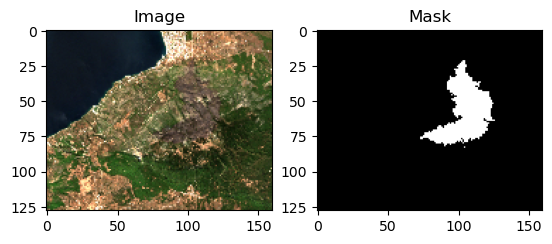

In [80]:
for batch_idx, (images, masks) in enumerate(train_dataloader):
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    print(type(images))
    print(type(masks))
    # Отображение первого изображения и маски в батче
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # нормализация для отображения
    
    mask = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()
    if batch_idx == 4:
        break

Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


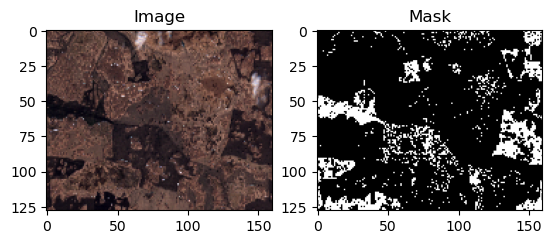

Batch 2
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


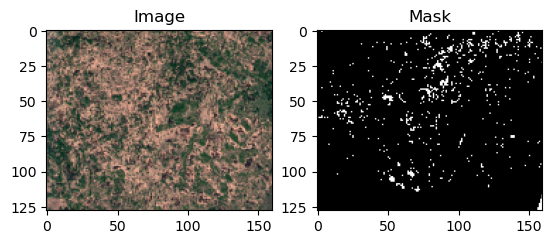

Batch 3
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


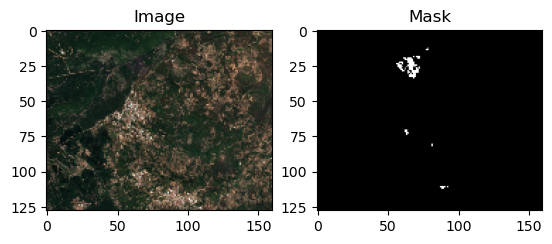

Batch 4
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


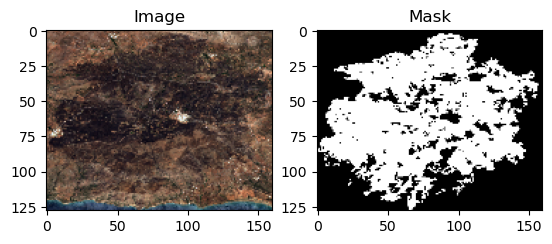

Batch 5
Images shape: torch.Size([1, 3, 128, 160])
Masks shape: torch.Size([1, 1, 128, 160])


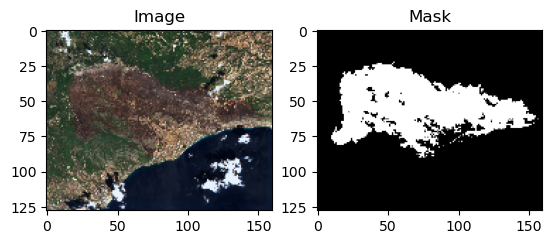

In [81]:
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    # Отображение первого изображения и маски в батче
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())  # нормализация для отображения
    
    mask = masks[0].squeeze(0).cpu().numpy()
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    
    plt.show()
    if batch_idx == 4:
        break

# Let’s initialize the model and write functions for training - С инициализируем модель и пропишим функции для обучения

In [82]:
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
loss_function = torch.nn.BCEWithLogitsLoss()

In [83]:
def train_one_epoch(data_loader, num_ep, metric_f: Metrics):
    global device, model, optimizer, loss_function
    model.train()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0,
        'mcc': 0.0
    }
    print(f'Epoch train: {num_ep + 1}')
    print('-----------------------------------')
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        
        batch_size = x_batch.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
        output_sigmoid = torch.sigmoid(output)
        metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
        metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
        metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
        metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
        metric_res['mcc'] += metric_f.matthews_corrcoef(y_batch, output_sigmoid) * batch_size
        
        loss.backward()
        optimizer.step()
        
    avg_loss = total_loss / total_samples
    print(f'Loss train: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    return avg_loss, metric_res


def validation_one_epoch(data_loader, metric_f: Metrics):
    global device, model, loss_function
    model.eval()
    total_loss = 0.0
    total_samples = 0
    metric_res = {
        'f1_score': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0,
        'mcc': 0.0
    }
    for batch_index, batch in enumerate(tqdm_notebook(data_loader)):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            
            batch_size = x_batch.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            output_sigmoid = torch.sigmoid(output)
            metric_res['f1_score'] += metric_f.f1_score(y_batch, output_sigmoid) * batch_size
            metric_res['precision'] += metric_f.precision(y_batch, output_sigmoid) * batch_size
            metric_res['recall'] += metric_f.recall(y_batch, output_sigmoid) * batch_size
            metric_res['accuracy'] += metric_f.accuracy(y_batch, output_sigmoid) * batch_size
            metric_res['mcc'] += metric_f.matthews_corrcoef(y_batch, output_sigmoid) * batch_size
            
    avg_loss = total_loss / total_samples
    print(f'Loss validation: {avg_loss}')
    metric_res = {i: metric_res[i] / total_samples for i in metric_res}
    for metric in metric_res:
        print(f'{metric}: {metric_res[metric]}')
    print('-----------------------------------')
    print()
    return avg_loss, metric_res


In [84]:
epoches = 16

train_losses = []
metric_res_train = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': [],
    'mcc': []
}

valid_losses = []
metric_res_valid = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'accuracy': [],
    'mcc': []
}

best_metrics = {
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
    'accuracy': 0,
    'mcc': 0
}
best_model_wts = 'model'
min_loss = 10 ** 9
step_flag = 2

for epoch in range(epoches):
    if epoch % step_flag == 0:
        losses_train_epoch, metric_res_train_epoch = train_one_epoch(orig_train_dataloader, epoch, Metrics)
        train_losses.append(losses_train_epoch)
        for i in metric_res_train_epoch:
            metric_res_train[i].append(metric_res_train_epoch[i])
    else:
        losses_train_epoch, metric_res_train_epoch = train_one_epoch(train_dataloader, epoch, Metrics)
        train_losses.append(losses_train_epoch)
        for i in metric_res_train_epoch:
            metric_res_train[i].append(metric_res_train_epoch[i])
    
    losses_val_epoch, metric_res_val_epoch = validation_one_epoch(valid_dataloader, Metrics)
    valid_losses.append(losses_val_epoch)
    for i in metric_res_val_epoch:
        metric_res_valid[i].append(metric_res_val_epoch[i])
    
    if any([best_metrics[i] < metric_res_val_epoch[i] for i in metric_res_val_epoch]) and min_loss > losses_val_epoch:
        best_model_wts = model.state_dict()
        best_metrics = {i: metric_res_val_epoch[i] for i in metric_res_val_epoch}
        min_loss = losses_val_epoch
    
    scheduler.step(losses_val_epoch)

Epoch train: 1
-----------------------------------


/tmp/ipykernel_19814/4119536274.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.8307519430162931
f1_score: 0.5159003186707545
precision: 0.4398364666284937
recall: 0.7491400831877583
accuracy: 0.18609557315857725
mcc: nan


/tmp/ipykernel_19814/4119536274.py:56: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_index, batch in enumerate(tqdm_notebook(data_loader)):


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -1.435828836191268
f1_score: 0.720184692314693
precision: 4.6983909622899125
recall: 0.7455092242785862
accuracy: 0.21114908478089742
mcc: nan
-----------------------------------

Epoch train: 2
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.8161781887815456
f1_score: 0.5321071379714541
precision: 0.4514232263571084
recall: 0.770296001675153
accuracy: 0.1874972872360788
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 5.772545587448847
f1_score: 0.22778503561303728
precision: 4.3915090053564025
recall: 0.16403362296876453
accuracy: 0.6285737610998607
mcc: nan
-----------------------------------

Epoch train: 3
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.813304819693469
f1_score: 0.5318059785046962
precision: 0.452059718921329
recall: 0.7729703783988953
accuracy: 0.19022426287634203
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -1.4399881249382382
f1_score: 0.7088734496917043
precision: 4.859849672054961
recall: 0.7208735942840576
accuracy: 0.2425153468336378
mcc: nan
-----------------------------------

Epoch train: 4
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.8290904487925347
f1_score: 0.5260042998224798
precision: 0.4391425708779181
recall: 0.7539273358956732
accuracy: 0.1856016226188101
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 5.842703441778819
f1_score: 0.232001074722835
precision: 4.469547473603771
recall: 0.1684982648917607
accuracy: 0.6292387502534049
mcc: nan
-----------------------------------

Epoch train: 5
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.8021994174429865
f1_score: 0.5383613928399905
precision: 0.45622627070230065
recall: 0.7741166350215373
accuracy: 0.19283089681406212
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -1.2548726059141613
f1_score: 0.70042556311403
precision: 5.035457986096541
recall: 0.7108315626780192
accuracy: 0.26015392868291765
mcc: nan
-----------------------------------

Epoch train: 6
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7939000855190586
f1_score: 0.5439594165995868
precision: 0.46179073507135565
recall: 0.7859705548093776
accuracy: 0.19054584107314698
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 5.613429830187843
f1_score: 0.24486784920805976
precision: 4.531196764714661
recall: 0.1785692586785271
accuracy: 0.6286039735589709
mcc: nan
-----------------------------------

Epoch train: 7
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7938990282891977
f1_score: 0.5450686155395075
precision: 0.46018817132771617
recall: 0.7826727809328021
accuracy: 0.195153193115586
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -0.8287873864173889
f1_score: 0.6728327196268808
precision: 4.6586322245143705
recall: 0.698698293595087
accuracy: 0.26251859962940216
mcc: nan
-----------------------------------

Epoch train: 8
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.8061054201815465
f1_score: 0.5402160891980836
precision: 0.45288247156022776
recall: 0.7815775323395777
accuracy: 0.19266493091679582
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 6.962719011874426
f1_score: 0.22829708066724597
precision: 4.005596683671077
recall: 0.17204181849956512
accuracy: 0.6216122621581668
mcc: nan
-----------------------------------

Epoch train: 9
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7917633387777541
f1_score: 0.5456468938577055
precision: 0.46165340589453474
recall: 0.7890916096441674
accuracy: 0.19577069384883147
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -1.3587806906018938
f1_score: 0.722409015255315
precision: 4.81798125856689
recall: 0.7433093161810012
accuracy: 0.24682384658427464
mcc: nan
-----------------------------------

Epoch train: 10
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.812154678985326
f1_score: 0.5422045864691638
precision: 0.44779181480407715
recall: 0.7806424564785428
accuracy: 0.19280894860775785
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 5.113536485603878
f1_score: 0.25247441764388767
precision: 4.3477151697235445
recall: 0.18942446226165408
accuracy: 0.6086193266369048
mcc: nan
-----------------------------------

Epoch train: 11
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7838729558267978
f1_score: 0.5524603203691617
precision: 0.4651360053456191
recall: 0.7971320089065668
accuracy: 0.19860544003019429
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -0.8508897849491665
f1_score: 0.6785538746487527
precision: 4.602836539702756
recall: 0.6976449148995536
accuracy: 0.25468518265656065
mcc: nan
-----------------------------------

Epoch train: 12
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7944501221480996
f1_score: 0.5417354803043183
precision: 0.4608950729133806
recall: 0.7923685330333132
accuracy: 0.19198331161580903
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 5.8240201615151905
f1_score: 0.2386155625184377
precision: 4.124779979033129
recall: 0.1788929963395709
accuracy: 0.6203473806381226
mcc: nan
-----------------------------------

Epoch train: 13
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7910019275214937
f1_score: 0.5424967975628496
precision: 0.4620177863598472
recall: 0.7874370966896866
accuracy: 0.19650928111690463
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -1.4235856391134716
f1_score: 0.726266381641229
precision: 4.9938350930100395
recall: 0.741944704736982
accuracy: 0.2548107370024636
mcc: nan
-----------------------------------

Epoch train: 14
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7877555581355336
f1_score: 0.55073493997557
precision: 0.462477660841412
recall: 0.7889611124992371
accuracy: 0.1931440874633163
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 4.719697915372395
f1_score: 0.2610010767266864
precision: 4.538871222131309
recall: 0.19252495822452365
accuracy: 0.6120675191992805
mcc: nan
-----------------------------------

Epoch train: 15
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.7945411707265209
f1_score: 0.5474241793607221
precision: 0.4588263821647023
recall: 0.79120432156505
accuracy: 0.19802517383688628
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: -1.0252300273804438
f1_score: 0.686817654186771
precision: 4.855781226285866
recall: 0.7184724523907616
accuracy: 0.25294131182488944
mcc: nan
-----------------------------------

Epoch train: 16
-----------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Loss train: 0.800638585304371
f1_score: 0.5414628174268838
precision: 0.454431193570296
recall: 0.7816420621944197
accuracy: 0.19176555575445445
mcc: nan


  0%|          | 0/5 [00:00<?, ?it/s]

Loss validation: 4.763830826396034
f1_score: 0.25685775102604
precision: 4.3805816276442435
recall: 0.19311073706263587
accuracy: 0.6065522687775748
mcc: nan
-----------------------------------



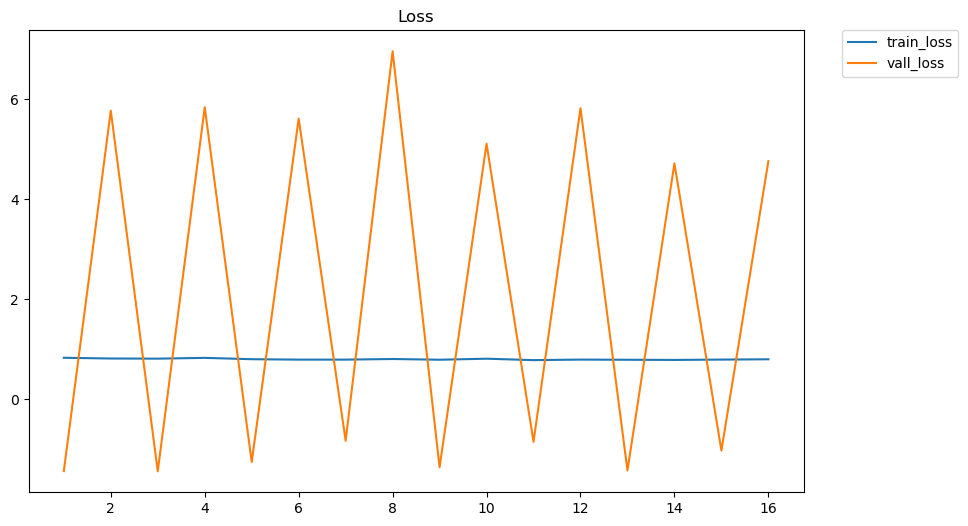

In [85]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label="train_loss")
plt.plot(np.arange(1, len(valid_losses) + 1), valid_losses, label="vall_loss")
plt.title("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

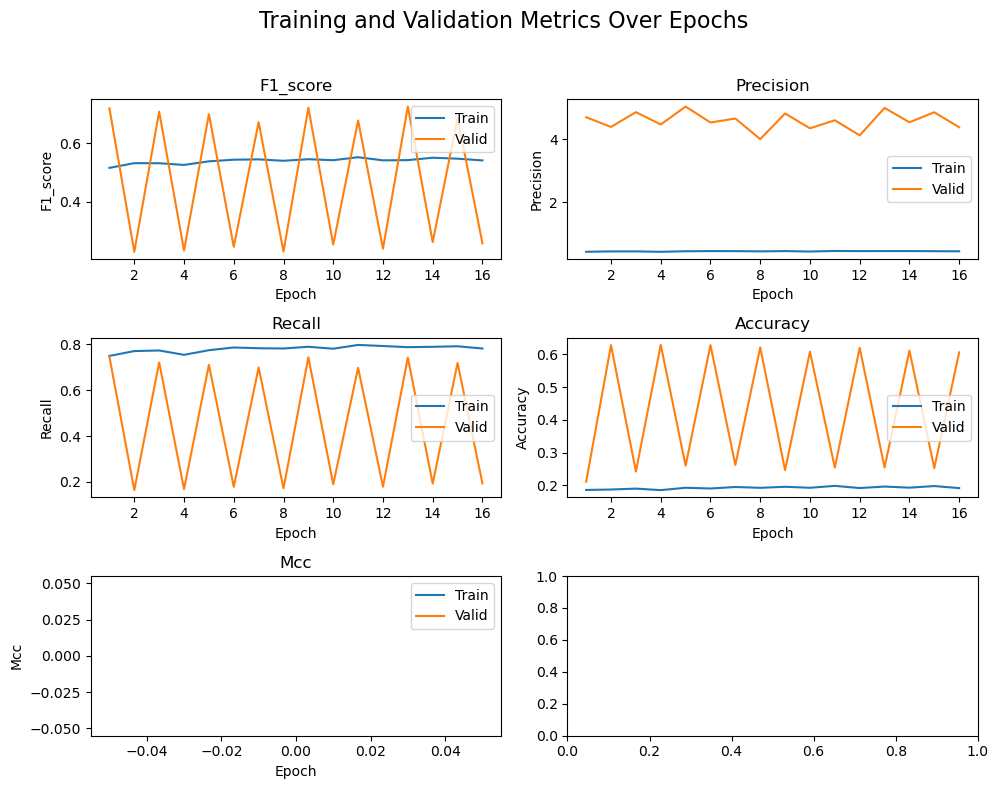

In [86]:
metrics = ['f1_score', 'precision', 'recall', 'accuracy', 'mcc']
epochs = range(1, len(metric_res_train['f1_score']) + 1)
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
for ax, metric in zip(axes.flatten(), metrics):
    ax.plot(epochs, metric_res_train[metric], label='Train')
    ax.plot(epochs, metric_res_valid[metric], label='Valid')
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [87]:
print(f'best_metrics: {best_metrics}')
print(f'best_loss: {min_loss}')

best_metrics: {'f1_score': 0.7088734496917043, 'precision': 4.859849672054961, 'recall': 0.7208735942840576, 'accuracy': 0.2425153468336378, 'mcc': nan}
best_loss: -1.4399881249382382


In [88]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

# Visualizing the model's predictions - Визуализируем предсказания модели

Batch 1
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


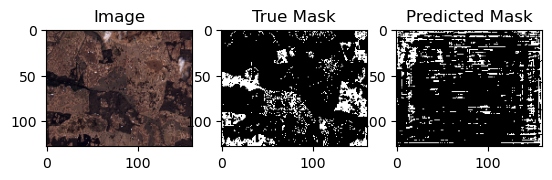

Batch 2
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


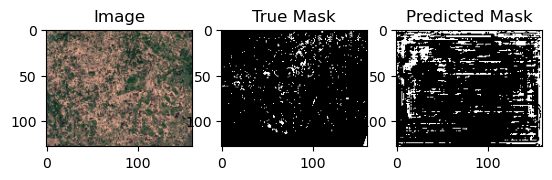

Batch 3
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


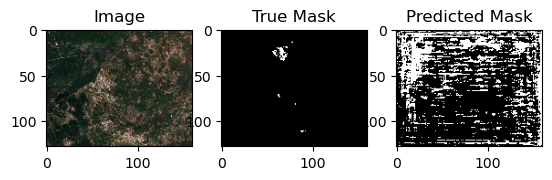

Batch 4
Images shape: torch.Size([5, 3, 128, 160])
Masks shape: torch.Size([5, 1, 128, 160])


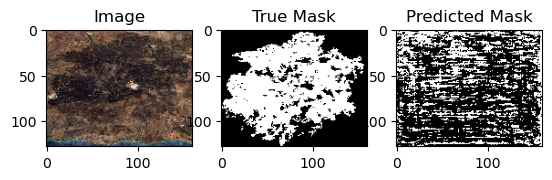

Batch 5
Images shape: torch.Size([1, 3, 128, 160])
Masks shape: torch.Size([1, 1, 128, 160])


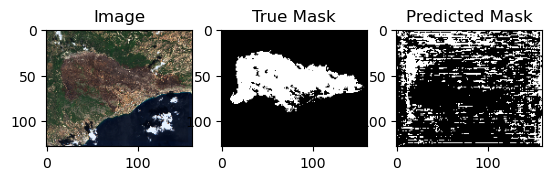

In [89]:
for batch_idx, (images, masks) in enumerate(valid_dataloader):
    model.eval()
    print(f'Batch {batch_idx + 1}')
    print(f'Images shape: {images.shape}')
    print(f'Masks shape: {masks.shape}')
    
    with torch.no_grad():
        predictions = model(images.to(device))
    
    image = images[0].permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    
    mask_true = masks[0].squeeze(0).cpu().numpy()
    
    # print(torch.round(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0)))

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("True Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.round(torch.sigmoid(predictions[0]).cpu().permute(1, 2, 0)).detach().numpy(), cmap='gray')
    plt.title("Predicted Mask")
    
    plt.show()